# Comparing Run time of Deep Learning Model and Classic Clustering Algorithms

In [1]:
import sklearn as sk
import pandas as pd
import keras as kr
import time
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

Using TensorFlow backend.


# Reading the wine Data from users

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


# Data Wrangling

In [4]:
merged = pd.merge(df_transactions, df_offers)
pivoted = merged.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
pivoted

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Text(0, 0.5, 'Sum of Squares')

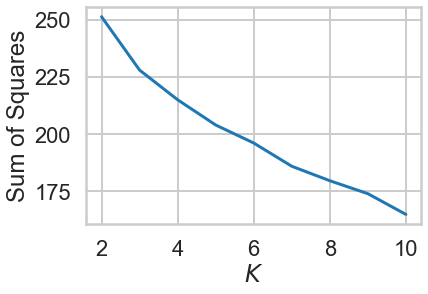

In [5]:
import sklearn.cluster
import numpy as np

ss = []
assignments = {}
X = pivoted.as_matrix()
Krange = list(range(2, 11))
for K in Krange:
    model = sklearn.cluster.KMeans(n_clusters=K)
    assigned_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster
plt.plot(Krange, ss)
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")

3


([<matplotlib.axis.XTick at 0x1a325129d0>,
 <a list of 3 Text xticklabel objects>)

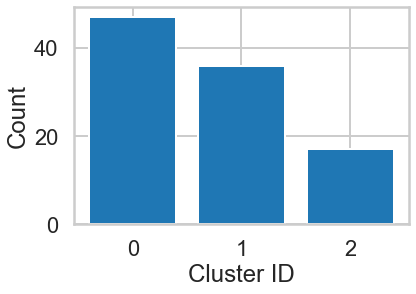

In [6]:
best_K = 3
assignments_best_K = assignments[str(best_K)]
counts = np.bincount(assignments_best_K)
print(len(counts))
plt.bar(range(best_K), counts, align='center')
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.xticks(range(best_K))

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

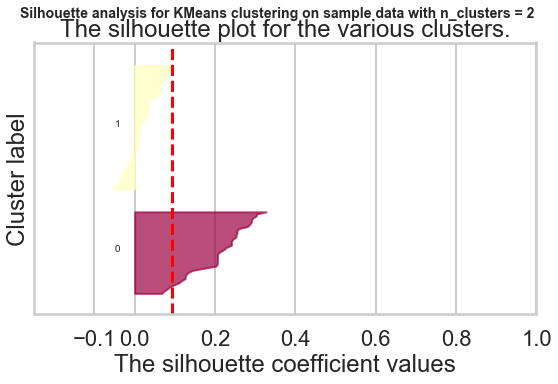

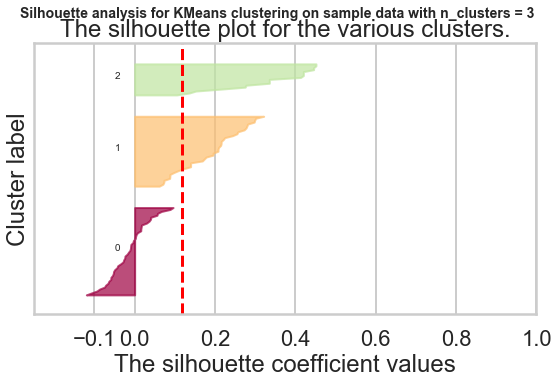

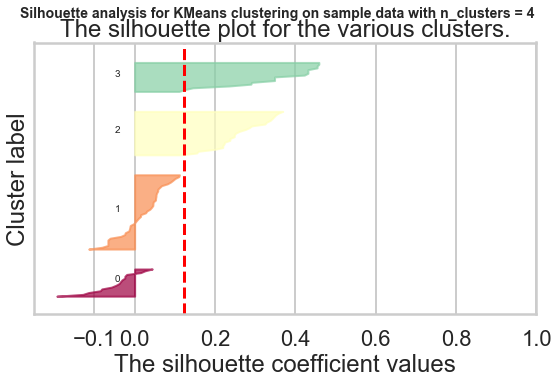

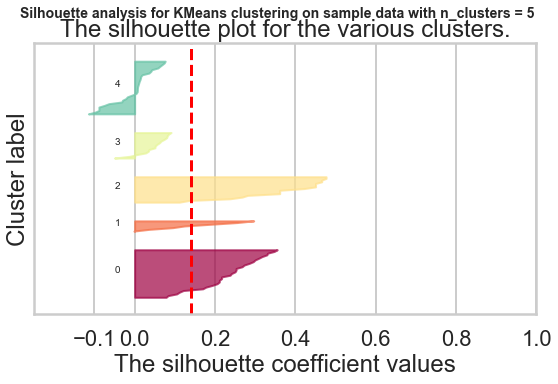

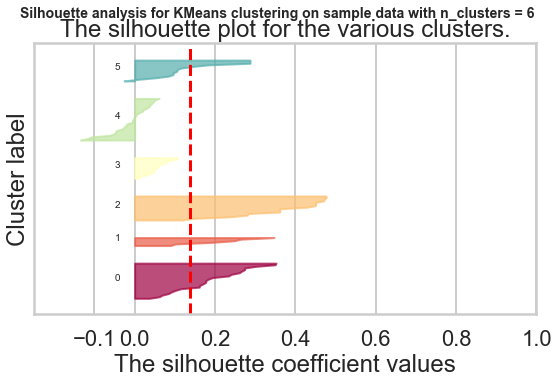

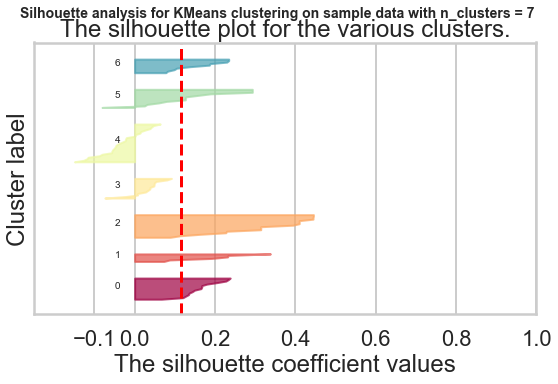

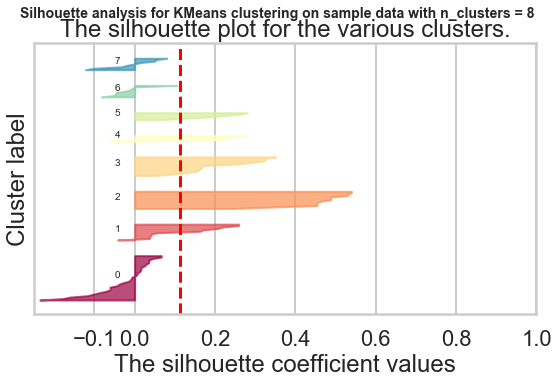

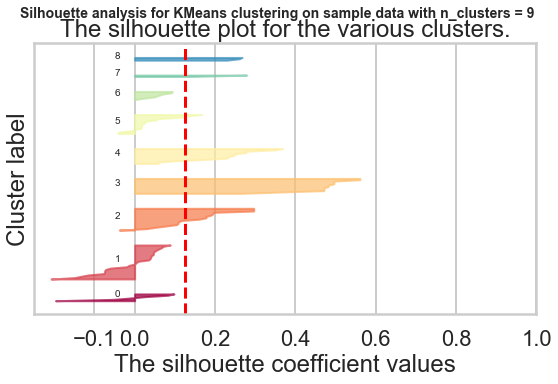

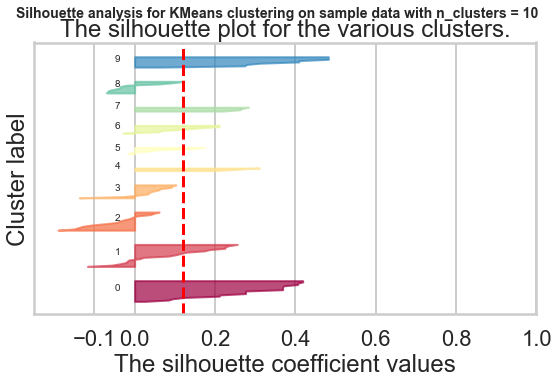

In [7]:
import sklearn.metrics
import matplotlib.pyplot as plt

avg_silhouette_scores = []
for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=K, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.get_cmap("Spectral")(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')

Text(0, 0.5, 'Average Silhouette Score')

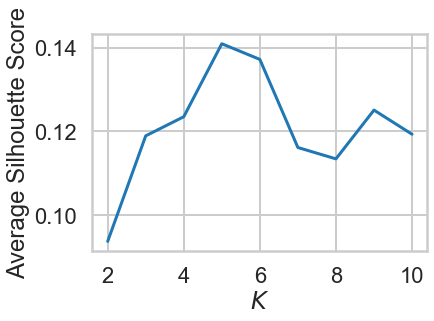

In [8]:
plt.plot(Krange, avg_silhouette_scores)
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

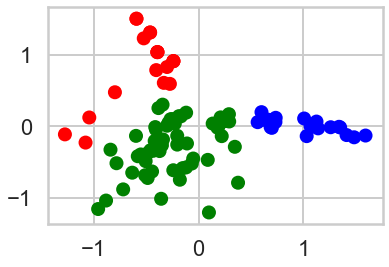

In [9]:
import sklearn.decomposition
import matplotlib.colors

model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)

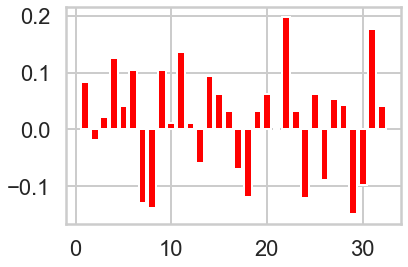

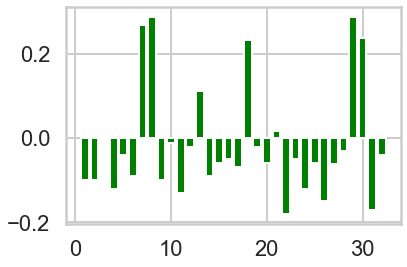

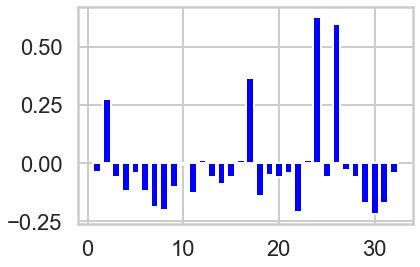

In [10]:
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

colors = ['red', 'green', 'blue']
offer_proportions = pivoted.sum(axis=0) / 100  # There are 100 customers
for i in range(3):
    plt.figure(i)
    cluster = pivoted[cluster_assignments == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions
    plt.bar(range(1, 33), lift, color=colors[i])

Text(0, 0.5, 'Proportion of Variance Explained')

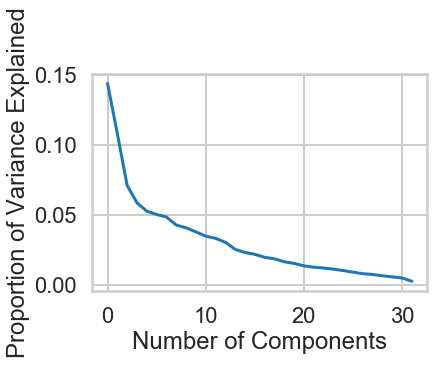

In [11]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
variance = pca.explained_variance_ratio_
plt.plot(range(len(variance)), variance)
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")

# Time it for 3 Clusters on Scikit-Learn Model

In [12]:
from timeit import default_timer as timer
start = timer()

model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

end = timer()

In [13]:
print("The run time for Scikit Learn is: ")
print(end - start)
print(X.shape)

The run time for Scikit Learn is: 
0.025591070000000826
(100, 32)


## Now for the Keras Cluster approach

In [14]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans

In [15]:
X = pivoted.as_matrix()
X = np.take(X,np.random.permutation(X.shape[0]),axis=0,out=X)


x_train = X[:70, :]
x_test = X[70:, :]

x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(70, 32)
(30, 32)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [16]:
encoding_dim = 32

input_X = Input(shape=(32, ))

encoded = Dense(encoding_dim, activation='relu')(input_X)
decoded = Dense(32, activation='sigmoid')(encoded)

autoencoder = Model(input_X, decoded)

In [17]:
encoder = Model(input_X, encoded)

# Placeholder for Model

In [18]:
encode_input = Input(shape=(encoding_dim,))
decoded_layer = autoencoder.layers[-1]

decoder = Model(encode_input, decoded_layer(encode_input))

In [19]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [20]:
# Scale the data before training
x_train = X.astype('float32')

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

print(x_train.shape)

(100, 32)


# Train Model

In [21]:
start2 = timer()
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, x_test))

end2 = timer()

Train on 100 samples, validate on 30 samples
Epoch 1/50
100/100 [==============================] - 0s 1ms/step - loss: 0.6821 - val_loss: 0.6685
Epoch 2/50
100/100 [==============================] - 0s 115us/step - loss: 0.6569 - val_loss: 0.6433
Epoch 3/50
100/100 [==============================] - 0s 105us/step - loss: 0.6308 - val_loss: 0.6162
Epoch 4/50
100/100 [==============================] - 0s 107us/step - loss: 0.6018 - val_loss: 0.5857
Epoch 5/50
100/100 [==============================] - 0s 104us/step - loss: 0.5687 - val_loss: 0.5513
Epoch 6/50
100/100 [==============================] - 0s 118us/step - loss: 0.5318 - val_loss: 0.5140
Epoch 7/50
100/100 [==============================] - 0s 108us/step - loss: 0.4926 - val_loss: 0.4763
Epoch 8/50
100/100 [==============================] - 0s 104us/step - loss: 0.4543 - val_loss: 0.4413
Epoch 9/50
100/100 [==============================] - 0s 110us/step - loss: 0.4193 - val_loss: 0.4111
Epoch 10/50
100/100 [==================

In [22]:
print(end - start)
print(end2 - start2) # This is training time per layer so for about 10 layer
                     # You can expect to be about 10 times longer.

0.025591070000000826
0.8882319790000004


## Results
| Method    | Run time in Seconds | Size of Data |
|-----------|---------------------|--------------|
| K-Means   | 0.0256              | 100x32       |
|   AWS     | 8.8823              | 100x32       |
